In [32]:
import matplotlib.pyplot as plt
import numpy as np
from lea_utils import norm_values
from lea_utils import SimulatorLEA
from lea_utils import APRBS
#%matplotlib tk  #Desabilita exibição de plot inline no notebook

In [33]:
#Intancia do simulador
simulador=SimulatorLEA()
#Carregar dados experimentais
filepath="./dados_experimentais/Dados_BCSLEA_20210818.mat"
intervalo_horas=(0,7) #Janela de simulação em horas escolhida com base no histórico de dados
simulador.getLEAdata(filepath,intervalo_horas)

0
 File loaded ./dados_experimentais/Dados_BCSLEA_20210818.mat


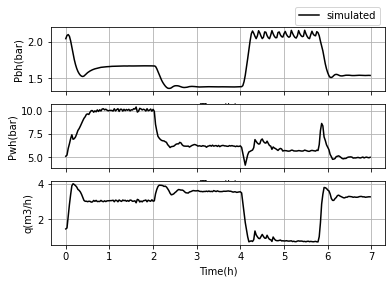

In [34]:
#Mostrar os dados de exógenas e estados
simulador.BCS_EXP.plot_ss

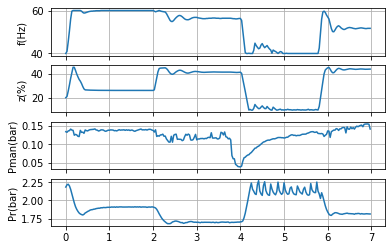

In [35]:
simulador.BCS_EXP.plot_u

### Simulação para confrontar com os dados experimentais

In [36]:
# =========================================================================
#  carrega as entradas, estados e valores iniciais do BCS LEA   
# =========================================================================
fk,zc,pman,pres=simulador.BCS_EXP.get_exo_values() # Armazenamento dos valores das exógenas
pbh,pwh,q=simulador.BCS_EXP.get_ss_values() # Armazenamento dos valores dos estados
u_0=np.array([fk[0],zc[0],pman[0],pres[0]]) #Valor inicial de entrada
u_exp=np.array([fk,zc,pman,pres])#Empacotamento entradas exógenas experimentais
x_0=np.array([pbh[0],pwh[0],q[0]])#Empacotamento valor inicial para os estados
x_exp=[pbh,pwh,q]
xss=x_0;uss=u_0 #Iniciar a simulação - nos valores iniciais
#####################################################
nsim=simulador.BCS_EXP.nsim# Time-steps para simulação
ts=simulador.BCS_EXP.ts #Sampling tim
tempo_hora = np.arange(0,nsim*ts,ts)/3600 # vetor de tempo em horas

In [37]:
####################
#Obter os fatores de escalonamento para simulação
xc,x0=norm_values()
####################
xssn = (xss-x0)/xc
#### Transformação para unidades de engenharia (bar, m3/h)
xscale=np.array([1/1e5,1/1e5,3600])
####


In [38]:
nstep = nsim
nsim=u_exp.shape[1]
a_range_f = [40,60] # intervalo de variação da variável
a_range_z = [20,45] # intervalo de variação da variável
a_range_pm =[0.02, 0.15]
a_range_pres =[2, 2.3]
hold_range = [30,50] # periodo de retenção em cada amplitude
u_f=APRBS(a_range_f,hold_range,nstep)
u_z=APRBS(a_range_z,hold_range,nstep)
u_pman=APRBS(a_range_pm,hold_range,nstep)
u_pres=APRBS(a_range_pres,hold_range,nstep)
uk = np.array([u_f,u_z,u_pman*1e5,u_pres*1e5]).T;
# uk_1 = np.array([np.ones_like(u_z)*40,u_z]);
# prfixo=1.8e5; pr2=np.ones_like(f2)*prfixo
# pmfixo=0.12e5;pm2=np.ones_like(f2)*pmfixo
# zfixo=35;zc2=np.ones_like(f2)*zfixo


In [39]:
#-------------------------------------------
#Definindo entradas exógenas a ser utilizada
#uk_1=u_exp.T
uss=uk[0,:]
print(uss)
#--------------------------------------------
xssn=simulador.regime_estacionario()(xssn,uss) #valor inicial normalizado
xpk=simulador.PredictionModel(ts)(xssn,uss)
xpks=xpk*xc+x0
#Inicialização do vetor de estados
Xk=xpks
#Inicialização do vetor de entradas exogenas
Uk= np.array(uss).reshape(1,4)
from tqdm.notebook import tqdm
for k in tqdm(range(1,nsim)):
    xpk = simulador.PredictionModel(ts)(xpk,uk[k:k+1,:])
    xpks=xpk*xc+x0
    Xk = np.concatenate((Xk,xpks),axis=0) #desnormalizar x e preencher vetor
    Uk = np.concatenate((Uk,uk[k:k+1,:]),axis=0)
Xk=[Xk[:,i] for i in range(3)]
Uk=[Uk[:,i] for i in range(4)]

[5.35670313e+01 3.55566256e+01 4.21305901e+03 2.12858638e+05]


  0%|          | 0/251 [00:00<?, ?it/s]

### Resultados

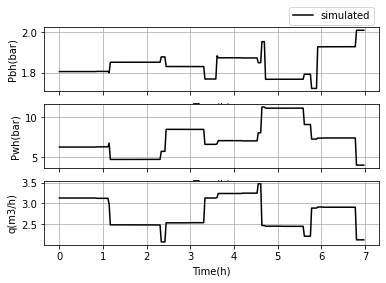

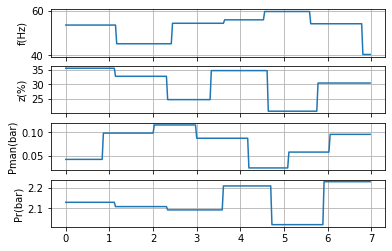

In [40]:
Fig_sim=simulador.plotLEA.plot_states([Xk],tempo_hora)
Fig_sim=simulador.plotLEA.plot_exogenous(Uk,tempo_hora)